# **Applied Deep Learning - Bi-weekly report 1 - Word Representations**
Preetham Prashanth Thava




In this biweekly report, I have used the word-analogy dataset from Microsoft https://www.microsoft.com/en-us/research/project/recurrent-neural-networks-for-language-processing/downloads/. This dataset was used mainly for computing syntactic similarities in between words of the form 'a is to b as c is to ?'. Finding the answer to '?' was the aim of this experiment. In the paper 'Linguistic Regularities in continuous space word representations', multiple language models are compared in predicting the vector closest to the answer of the analogy questions from the dataset. 

We can generate word vector representations for all words in the dataset, and then perform basic vector arithmetic operations to evaluate the answer to '?', through the Vector-Offset method.


## Importing required libraries

In [2]:
import numpy as np # for linear algebra
import pandas as pd # data processing, space separated file I/O (e.g. pd.read_csv)
import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.downloader

In [4]:
df_questions = pd.read_csv("./word_relationship.questions", names = ['A', 'B', 'C'], sep=' ')
df_answers = pd.read_csv("./word_relationship.answers", names = ['Type', 'D'], sep = ' ')

# Records on Pandas DataFrame are created through the concatenation of question words and answers, i.e., a,b,c and d respectively 
df = pd.concat([df_questions, df_answers], axis=1)
df.head()

,A,B,C,Type,D
0,good,better,rough,JJ_JJR,rougher
1,better,good,rougher,JJR_JJ,rough
2,good,best,rough,JJ_JJS,roughest
3,best,good,roughest,JJS_JJ,rough
4,best,better,roughest,JJS_JJR,rougher


When checking the occurences of word-analogy question types, we see that 16 types of equal counts are present as below.

In [5]:
df.Type.value_counts()

JJ_JJR      500
JJR_JJ      500
JJ_JJS      500
JJS_JJ      500
JJS_JJR     500
JJR_JJS     500
NN_NNS      500
NNS_NN      500
NN_NNPOS    500
NNPOS_NN    500
VB_VBD      500
VBD_VB      500
VB_VBZ      500
VBZ_VB      500
VBZ_VBD     500
VBD_VBZ     500
Name: Type, dtype: int64

In [6]:
all_abc_words = [word for words in df[['A', 'B', 'C']].values.tolist() for word in words]

When working on various experiments with the dataset, I found that column D or the answers to word-analogy questions is a subset of the vocabulary of the questions(a,b,c)

Hence, no text is output from the next cell

In [ ]:
for i in df.D:
    if i not in all_abc_words:
        print(i)

The below cell calculates the frequency counts for all words making up the vocabulary of the word-analogy questions.

In [7]:
df_vocab_ct = pd.concat([df.A,df.B,df.C])
df_vocab_ct.value_counts()

fast        46
become      46
became      46
becomes     46
show        46
            ..
season's    11
year's      11
museum's    11
museum      11
foot        11
Length: 966, dtype: int64

We see that, from below bar plot showing the top 50 most occurring terms in the questions vocabulary, many of the terms have equal counts, and very low outliers are present.

With the Pie plot, it become very clear that almost all words are having similar occurrence counts for the top 50 frequently occurring words.

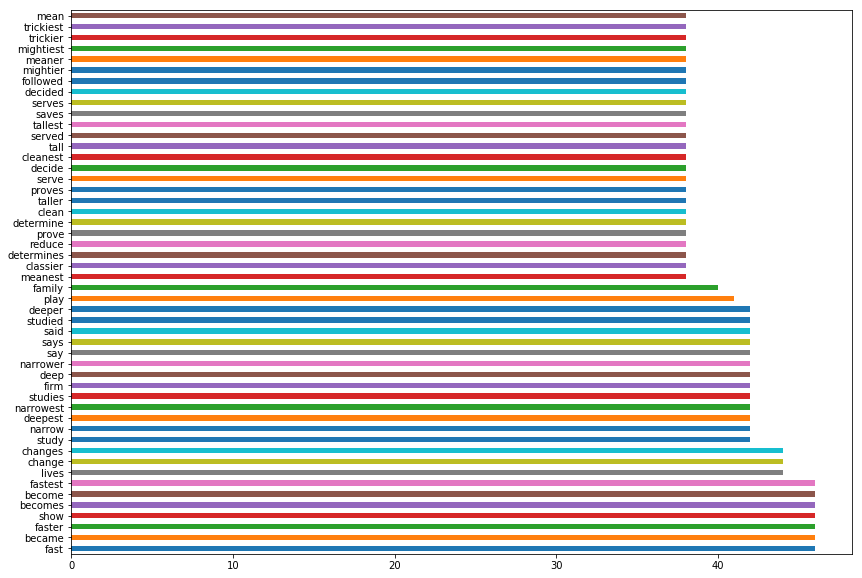

In [ ]:
df_vocab_ct.value_counts()[:50].plot(kind='barh', figsize = (14, 10))

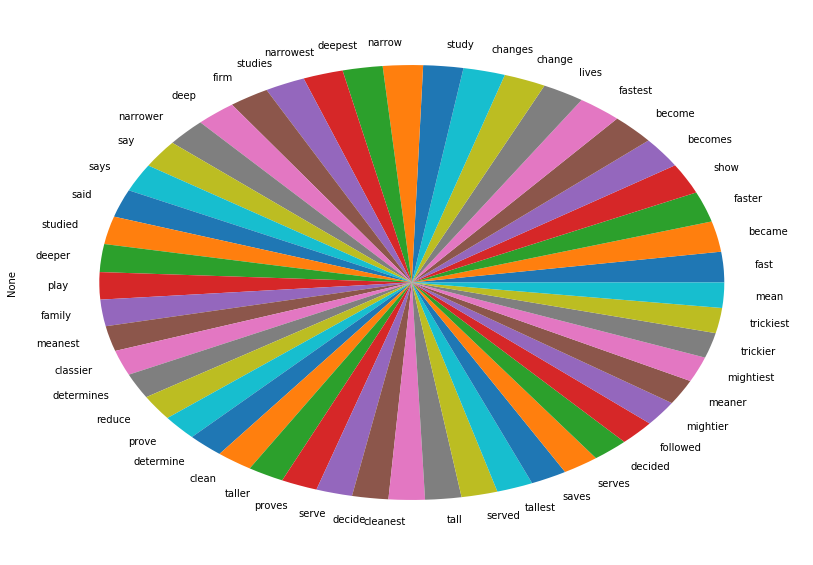

In [ ]:
df_vocab_ct.value_counts()[:50].plot(kind='pie', figsize = (14, 10))

From all of the above explorations, we can see that, most of the words in the dataset have been repeated, thus this plays a slightly important role in identifying word vectors values that is compatible with multiple contexts.

Eg: If word analogy question WQ1 is "greater great classier", and its answer is "classy" and
word analogy question WQ2 is "safer safe classier", and its answer is "classy"
Then, when word vectors are being trained, word 'classier' gets to be positioned such that it is in the context of both 'great, greater' and 'safe, safer' word vectors


In the below cell, we are creating sentences of the form 'a b c d' where a,b,c are word analogy question terms while d is the answer term.
This is because, for training and building word vector representations, either the local context(word2vec) or global context(GloVe) is used to evaluate the position of a word in a multi-dimensional plane. For gathering the context information, we need sentence form of inputs, thus we are creating sentences from the dataset.

In [8]:
df_values_sents = df[['A', 'B', 'C', 'D']].values.tolist()

# Exploring the Word2Vec model with vector dimensions of 5, 50 and 100

The 3 models of Word2vec with different dimensions are generated below, with the method of CBOW(Continuous Bag of Words)

In [9]:
modelw2v_5 = gensim.models.Word2Vec(size=5, window=1, min_count=2, sg=0, workers=10)
modelw2v_50 = gensim.models.Word2Vec(size=50, window=1, min_count=2, sg=0, workers=10)
modelw2v_100 = gensim.models.Word2Vec(size=100, window=1, min_count=2, sg=0, workers=10)

# prepare the vocabulary for all above Word2Vec models
modelw2v_5.build_vocab(df_values_sents)
modelw2v_50.build_vocab(df_values_sents)
modelw2v_100.build_vocab(df_values_sents)

Below I provide the definition of four parameters that we used to define a Word2Vec model:

* **size:** The size means the dimensionality of word vectors. It defines the number of tokens used to represent each word. Rule-of-thumb: If a dataset is small, then size should be small too. If a dataset is large, then size should be greater too. It's the question of tuning.

* **window:** The maximum distance between the target word and its neighboring word. For example, let's take the phrase "agama is a reptile " with 4 words (suppose that we do not exclude the stop words). If window size is 2, then the vector of word "agama" is directly affected by the word "is" and "a". Rule-of-thumb: a smaller window should provide terms that are more related (of course, the exclusion of stop words should be considered). This parameter doesnt matter much to us, since the word analogy dataset has only 4 words in each record, so the window is set to 1 or 2.

* **min_count:** Ignores all words with total frequency lower than this. For example, if the word frequency is extremally low, then this word might be considered as unimportant.

* **sg:** Selects training algorithm: 1 for Skip-Gram; 0 for CBOW (Continuous Bag of Words). I used the CBOW method, since in this method, given a context a single vector is output, rather than outputting multiple vectors given a single word vector(as in Skip Gram architecture).

* **workers:** The number of worker threads used to train the model.

More details about input parameters can be found [here](http://radimrehurek.com/gensim/models/word2vec.html).

Training of the Word2Vec models are carried out below for 3 epochs

In [10]:
modelw2v_5.train(sentences=df_values_sents, total_examples=modelw2v_5.corpus_count, epochs=3)
modelw2v_50.train(sentences=df_values_sents, total_examples=modelw2v_50.corpus_count, epochs=3)
modelw2v_100.train(sentences=df_values_sents, total_examples=modelw2v_100.corpus_count, epochs=3)

(96000, 96000)

Each of the model is being trained with the same dataset, but leads to different vector dimensions in output. In total, 966 unique words are present in the dataset excluding the type of relation.

In [ ]:
wv5 = modelw2v_5.wv
wv50 = modelw2v_50.wv
wv100 = modelw2v_100.wv

In [ ]:
len(modelw2v_5.wv.vocab), len(modelw2v_50.wv.vocab), len(modelw2v_100.wv.vocab)

(966, 966, 966)

The below code is for computing vector cosine similarity, or the angle between two vectors in a multi-dimensional plane.
If vector cosine distance is 1, then both vectors are same 

More the value of cosine similarity, More the similarity between given two vectors

In [ ]:
#found this from article - https://stackoverflow.com/questions/21979970/how-to-use-word2vec-to-calculate-the-similarity-distance-by-giving-2-words
def vec_cosine_dist(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)* np.linalg.norm(v2))

Evaluating vector-offset method on Word2Vec for all 3 models below, and how it performs.

In [ ]:
#           A  :  B  ::   C   :   D
words = 'tough tougher strong stronger'.split()

In [ ]:
modelw2v_5.most_similar(positive=[words[1], words[2]], negative=[words[0]], topn=10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('protect', 0.9264461994171143),
 ('work', 0.9137416481971741),
 ('send', 0.8600581884384155),
 ('meanest', 0.8225146532058716),
 ('jobs', 0.820286214351654),
 ('offered', 0.8184273838996887),
 ('industry', 0.8175363540649414),
 ("agency's", 0.810515820980072),
 ('dollars', 0.7730557918548584),
 ("district's", 0.7633900046348572)]

In [ ]:
modelw2v_50.most_similar(positive=[words[1], words[2]], negative=[words[0]], topn=10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('pricey', 0.4449365735054016),
 ('nicest', 0.40004390478134155),
 ('needs', 0.39628908038139343),
 ('systems', 0.3871038854122162),
 ('cheaper', 0.38386937975883484),
 ('livelier', 0.3671429455280304),
 ('improved', 0.3647782504558563),
 ('lucky', 0.3587520718574524),
 ('quick', 0.3573203682899475),
 ('larger', 0.3553037941455841)]

In [ ]:
modelw2v_100.most_similar(positive=[words[1], words[2]], negative=[words[0]], topn=10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sought', 0.4213271737098694),
 ('oldest', 0.4181406497955322),
 ('quick', 0.39098942279815674),
 ('liveliest', 0.38770347833633423),
 ('pays', 0.379044771194458),
 ('included', 0.3773754835128784),
 ('poor', 0.36933255195617676),
 ('steadiest', 0.3659106194972992),
 ('pricier', 0.365082323551178),
 ('cheaper', 0.3644378185272217)]

So, from the above cells, we see that the answer vector is predicted to be either 'protect' with 5 dimensional vector, 'pricey' with 50 dimensional vector and 'sought' with 100 dimensional vector.
But, the answer according to the dataset and conventional knowledge is 'stronger' which neither of the model's top 10 answers consisted of.

2 observations from the above:
- The similarity scores keep reducing with increase in dimensionality of Word2Vec models
    -- This may be because of less data to train the model and computed vectors don't depict the words properly or that the vector offset method isn't good enough to predict the right analogy term. It needs to be improved further, maybe with a different train of thought such as actually understanding the word and its meaning rather than predicting the context of where the words are present in a text passage.
    
- A very few number of words repeat in the top 10 answers of all 3 models -- This maybe because of how the training process occurs, for each model the question term vectors are placed at different positions in the plane, and thus output different word vectors which are near to the predicted analogy answer term.

In [ ]:
vec_cosine_dist(wv5[words[1]]+wv5[words[2]]-wv5[words[0]], wv5[words[3]])

-0.21260452

In [ ]:
vec_cosine_dist(wv50[words[1]]+wv50[words[2]]-wv50[words[0]], wv50[words[3]])

0.22451892

In [ ]:
vec_cosine_dist(wv100[words[1]]+wv100[words[2]]-wv100[words[0]], wv100[words[3]])

0.29398978

The above 3 cells show the vector cosine distance between the predicted vector from the offset method to the actual word vector which is the answer term. With increase in dimensionality, the similarity of the predicted word with the true word is increasing.

# Explore the Glove model

In [ ]:
!pip install glove_python

    100% |████████████████████████████████| 266kB 1.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for glove-python ... done
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python
mxnet 1.3.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.2 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement numpy<1.15,>=1.13, but you'll have numpy 1.15.2 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1.post2 which is incompatible.
anaconda-client 1.7.2 has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.6.0 which is incompatible.
imbalanced-learn 0.5.0.dev0 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.1 which is incompatible.
You are using pip version 10.0.1, however vers

In [ ]:
lines = df_values_sents

In [ ]:
# taken from article - https://stackoverflow.com/a/56749028
from glove import Corpus, Glove

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co-occurrence matrix which is used in GloVe
corpus.fit(lines, window=10)

# In this method of generating word vectors, we generate only 5 dimensional ones to evaluate the dataset.
glove = Glove(no_components=5, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


An example of extracting GloVe word vectors from the model for the word 'rough'

In [ ]:
glove.word_vectors[glove.dictionary['rough']]

array([ 0.1048932 , -0.1623211 ,  0.5340166 , -0.27372773,  0.16959196])

In [ ]:
wa, wb, wc = glove.word_vectors[glove.dictionary[words[0]]], glove.word_vectors[glove.dictionary[words[1]]], glove.word_vectors[glove.dictionary[words[2]]]

In [ ]:
# The vector offset method - (b - a + c ~= d)
# wd_pred is the predicted word vector from the offset method.
wd_pred = wb-wa+wc

In [ ]:
wd_true = glove.word_vectors[glove.dictionary[words[3]]]

The below cell checks and find the most probable word vector (from the vocabulary of the questions) which is nearest to the wd_pred(predicted word vector)

In [ ]:
# Find the most probable word from the questions vocabulary for this vector, excluding word vectors part of the question terms
max_dist = 0
ind = -1
wrd = ''
for i,w in enumerate(df_vocab_ct.unique()):
    dist = vec_cosine_dist(wd_p, glove.word_vectors[glove.dictionary[w]])
    if dist>max_dist and w not in words[:-1]:
        max_dist = dist
        ind = i
        wrd = w
print(ind, wrd, max_dist)

43 stronger 0.9894357823200026


The below cell checks and find the most probable word vector (from the vocabulary of the answer terms) which is nearest to the wd_pred(predicted word vector)

In [ ]:
# Find the most probable word from teh answers vocabulary for this vector, excluding word vectors part of the question terms
max_dist = 0
ind = -1
wrd = ''
for i,w in enumerate(df.D):
    dist = vec_cosine_dist(wd_pred, glove.word_vectors[glove.dictionary[w]])
    if dist>max_dist and w not in words[:-1]:
        max_dist = dist
        ind = i
        wrd = w
print(ind, wrd, max_dist)

378 stronger 0.9894357823200026


Hooray, GloVe was able to predict the right answer term 'stronger' for the word-analogy question. We see that both the above functions give the same word as output. This is because the answer terms are a subset of the question terms vocabulary.

This might be a good example which worked well for GloVe, but not so well for Word2Vec since GloVe considers global context as well as local context(Word2Vec) of a word to predict its vector representation.

Below is an example, where GloVe fails to predict the right answer term.

In [ ]:
words = "safe safest cheap cheapest".split()

In [ ]:
wa, wb, wc = glove.word_vectors[glove.dictionary[words[0]]], glove.word_vectors[glove.dictionary[words[1]]], glove.word_vectors[glove.dictionary[words[2]]]
wd_pred = wb-wa+wc

In [ ]:
# Find the most probable word from the questions vocabulary for this vector, excluding word vectors part of the question terms
max_dist = 0
ind = -1
wrd = ''
for i,w in enumerate(df_vocab_ct.unique()):
    dist = vec_cosine_dist(wd_pred, glove.word_vectors[glove.dictionary[w]])
    if dist>max_dist and w not in words[:-1]:
        max_dist = dist
        ind = i
        wrd = w
print(ind, wrd, max_dist)

763 want 0.9665399686011301


In [ ]:
vec_cosine_dist(wd_pred, wd_true)

0.8433155861535495

So, the GloVe embeddings predicted 'want' with a similarity of 0.96 than the actual answer to which the similarity score of the predicted vector is only 0.84

# Visualizations with U-MAP and PCA 

In [27]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=daeb6a0daaea37fc97b34a749fa7c1a7252f36c73ee754b9116d0907b7845ed6
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=8fb7c1640f677ee6fe12f09efe40716f61b1974868f2652335c2ae91709d816e
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [28]:
import umap

In [29]:
keys_ordered = list(modelw2v_100.wv.vocab.keys())
vecs_ordered = modelw2v_100.wv[modelw2v_100.wv.vocab.keys()]

Formatting the word vectors for all words, to be comaptible for U-MAP algorithm

In [30]:
arr_w2v = vecs_ordered[0]
for i in range(1, len(vecs_ordered)):
    arr_w2v = np.vstack((arr_w2v, vecs_ordered[i]))

In [31]:
# Taking only the first 300 entries, to visualize clearly on U-MAP
curr_w2v = arr_w2v[:300]
curr_keys = keys_ordered[:300]

In [32]:
# taken from the article - https://www.kaggle.com/code/simoneazeglio/word2vec-umap-w2vaugmentation/notebook#W2V-Naive-Augmentation
umap_emb = umap.UMAP(n_neighbors= 15, n_components = 2, target_metric = 'l1' , n_epochs = 500).fit_transform(curr_w2v)

In [33]:
from sklearn.preprocessing import LabelEncoder

# POS tagging

In [34]:
uniq_vocab = curr_keys

U-POS tags and specific POS tags are extracted from Spacy library and stored into a DataFrame

In [35]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(' '.join(uniq_vocab))
tok_texts, tok_pos, tok_tags = [], [], []
for token in doc:
    tok_texts.append(token.text)
    tok_pos.append(token.pos_)
    tok_tags.append(token.tag_)


In [36]:
pos_df = pd.DataFrame({
    'text': tok_texts,
    'pos': tok_pos,
    'tags': tok_tags
})

In [37]:
pos_df.pos.value_counts()

ADJ     214
ADV      41
NOUN     25
X        14
VERB      5
ADP       1
Name: pos, dtype: int64

In [38]:
label_encoder = LabelEncoder()
integer_encoded_pos = label_encoder.fit_transform(pos_df.pos)

The below figure shows how all word vectors with reduced dimensions are placed in a 2d plane, and the colours of the markers depict the POS tag they are associated to.

From the value_counts function before, we see that 'ADJ' has more count, thus many red marker dots are in the figure all over the picture.

U-MAP for POS tags


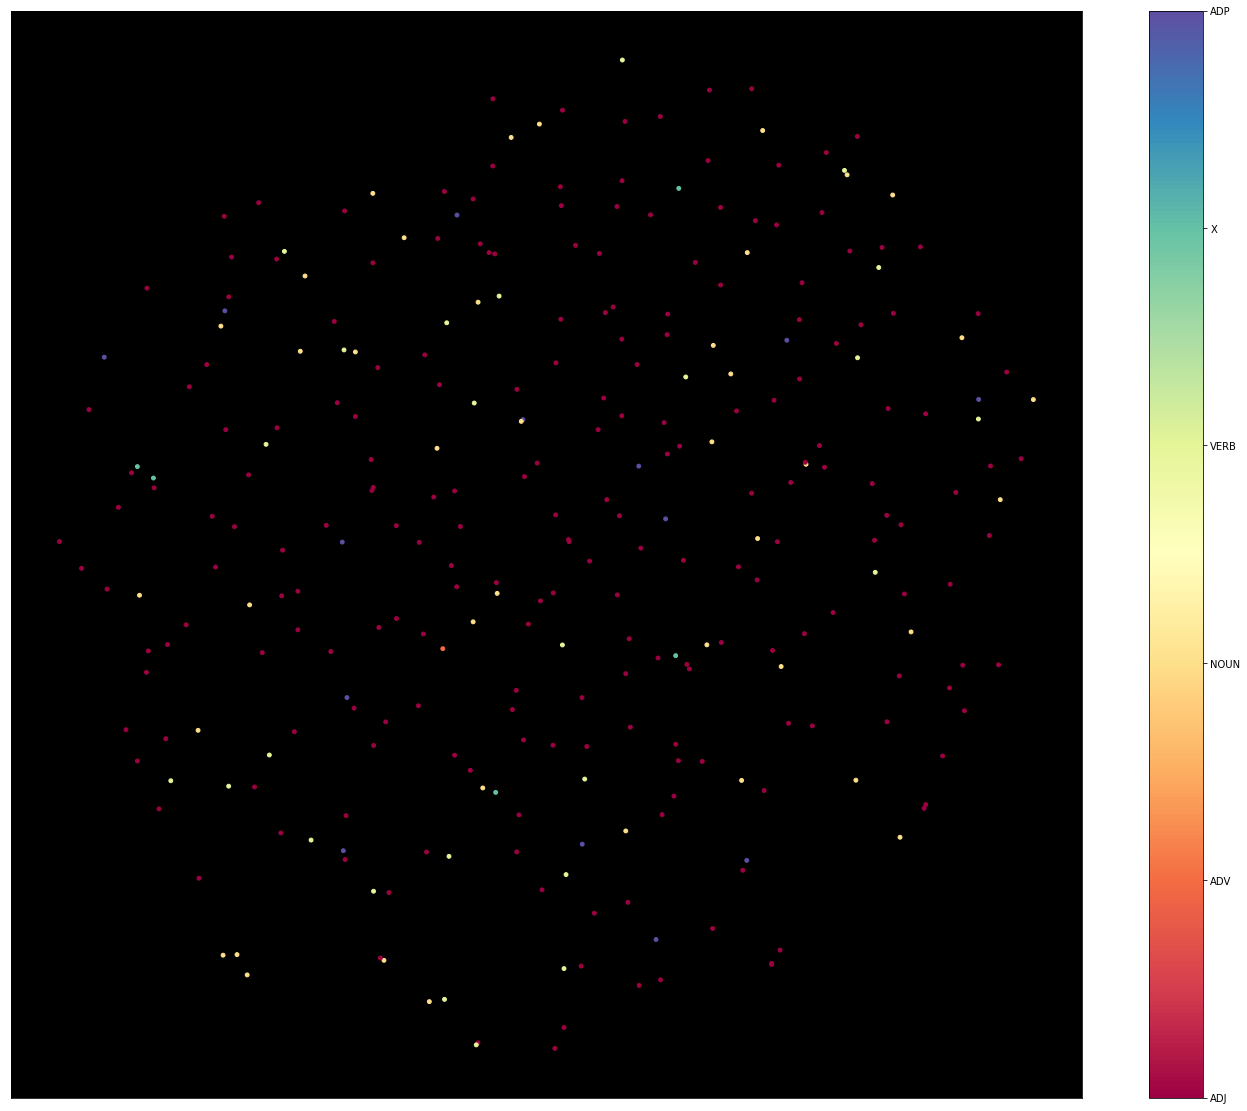

In [42]:
fig, ax = plt.subplots(1, figsize=(24, 20))
plt.scatter(*umap_emb.T, s=15, c = integer_encoded_pos, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(pos_df.pos.unique())
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)
print('U-MAP for POS tags')

In [ ]:
pos_df.tags.value_counts()

JJS    76
JJ     73
JJR    46
RBR    37
NN     30
RB     29
RBS     5
VB      2
VBP     1
VBD     1
Name: tags, dtype: int64

In [ ]:
label_encoder = LabelEncoder()
integer_encoded_tags = label_encoder.fit_transform(pos_df.tags)

The below figure shows how all word vectors with reduced dimensions are placed in a 2D plane, and the colours of the markers depict the specific POS tag they are associated to.

From the value_counts function before, we see that 'VBD' and 'VBP' has one count, thus only one blue and one purple marker dot is on the figure. 

U-MAP for specific POS tags


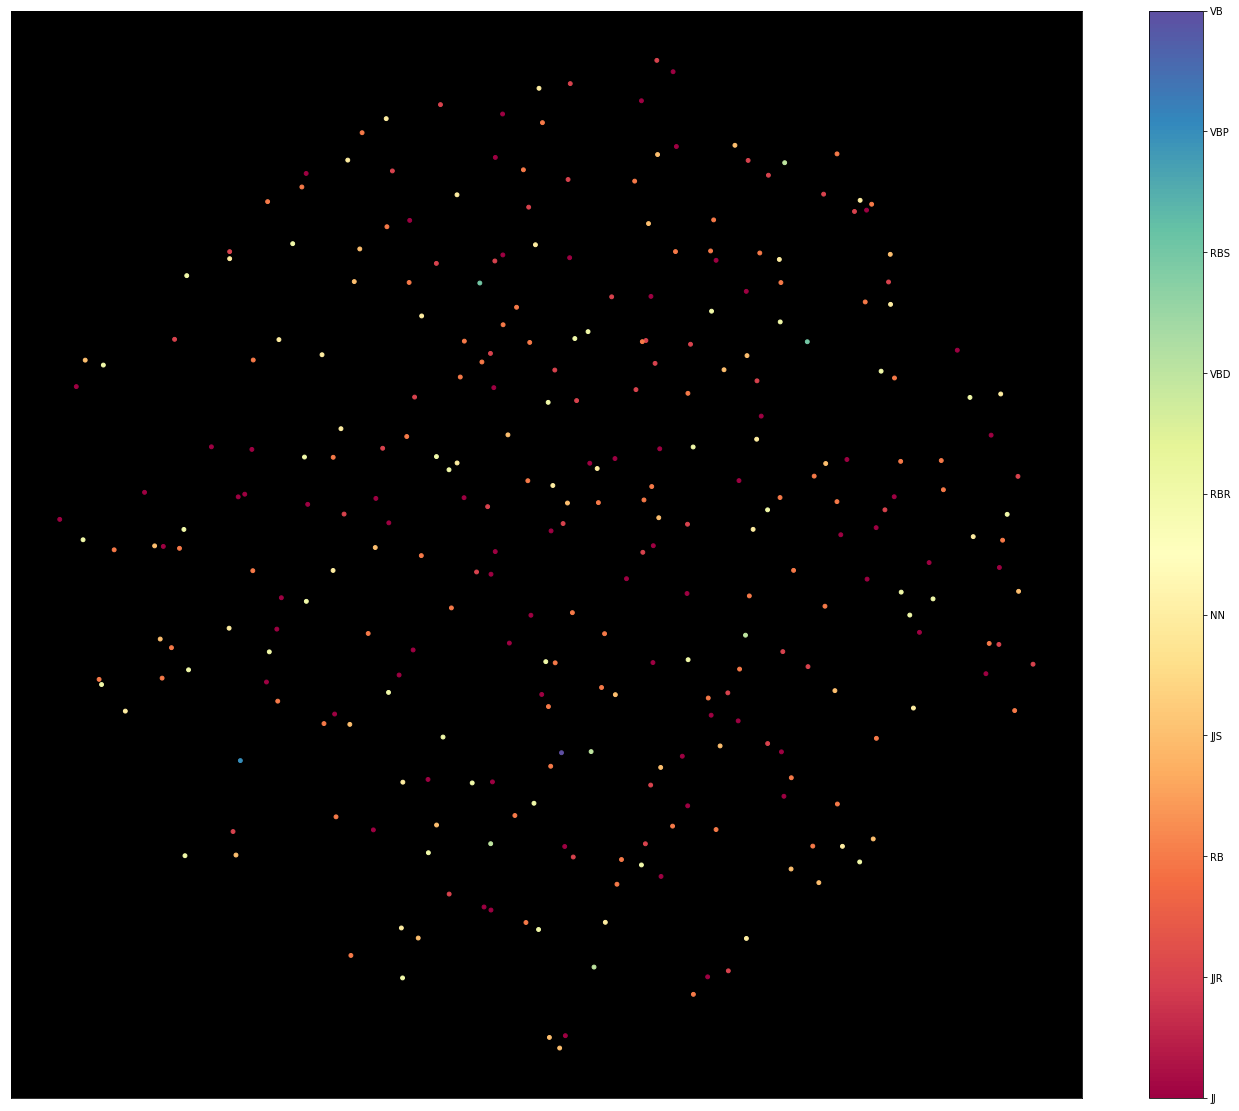

In [ ]:
fig, ax = plt.subplots(1, figsize=(24, 20))
plt.scatter(*umap_emb.T, s=15, c = integer_encoded_tags, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(pos_df.tags.unique())
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)
print('U-MAP for specific POS tags')

Honestly, I was expecting a more clustered representation of word vectors with respect to their POS tags.

This is probably because the word vector model has tried to understand the context without actually understanding grammatical nuances in the questions data. The latter form is how humans learn to answer word-analogy questions. So, the ML algorithms are far from developing that instinct to understand a question in its entirety and answer it. Rather, all the ML and DL models try to circumvent around every problem and convince the users that it has figured out the way to solve a given problem. 

Eg: Galactica, a DL model by Meta AI which generated research papers with content that made no sense, but was very convincing to a layman observer.

In [ ]:
!pip install plotly==5.13.0

  Using cached https://files.pythonhosted.org/packages/39/0e/df1664219b6ca7967ed76afd05fb71a1b9762f8da67e12206625395bd9ff/plotly-5.13.0-py2.py3-none-any.whl
mxnet 1.3.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.2 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement numpy<1.15,>=1.13, but you'll have numpy 1.15.2 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1.post2 which is incompatible.
anaconda-client 1.7.2 has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.6.0 which is incompatible.
imbalanced-learn 0.5.0.dev0 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.1 which is incompatible.
  Found existing installation: plotly 4.11.0
    Uninstalling plotly-4.11.0:
      Successfully uninstalled plotly-4.11.0
You are using pip version 10.0.1

In [44]:
# visualisation function taken from https://towardsdatascience.com/visualizing-word-embedding-with-pca-and-t-sne-961a692509f5
import plotly
import numpy as np
from plotly import graph_objs as go
from sklearn.decomposition import PCA

def display_pca_scatterplot_3D(model, user_input=None, words=None, label=None, color_map=None, topn=3, sample=10):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
    
    word_vectors = np.array([model[w] for w in words])
    
    three_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:3]
    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:2]

    data = []
    count = 0
    
    for i in range (len(user_input)):

                trace = go.Scatter3d(
                    x = three_dim[count:count+topn,0], 
                    y = three_dim[count:count+topn,1],  
                    z = three_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
#                     textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. Also, instead of using
                # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter3d(
                    x = three_dim[count:,0], 
                    y = three_dim[count:,1],  
                    z = three_dim[count:,2],
                    text = words[count:],
                    name = 'answer words',
                    textposition = "top center",
#                     textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()
    
user_input = ['richest', 'taller', 'stronger', 'cheapest']
similar_word = "large largest rich early earlier tall tough tougher strong safe safest cheap".split() + user_input
display_pca_scatterplot_3D(modelw2v_100, user_input, similar_word, labels, color_map)

<ipython-input-44-ec87ecb3b6b4>:15: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



From the above diagram, we can see how the answer words are positioned with respect to the words which make up the question terms. Out of the 4 question answer pairs visualized here, only one word pair was far from the answer term, i.e.,'taller' is far from its question terms.
Previously, when we tried to use the same model to compute vector offset method based distance, we werent able to arrive at a clear answer, but in this 3D perspective, we can see clearly the relationships.

 This is an excellent form of visualization in a 3D perspective to see how far each of the context words are in this dataset.

Thanks to Plotly, we can visualise only 1 word or 2 words at a time with its context question terms, by clicking on the legend in the figure above.

All the above functionalities are possible, when Plotly is run on a system, but it cant be made static, hence have added snaps of the figure, in the form of newplot_x.png in Github, please review them too.



## When can we use Word2Vec? <a name="usage"></a>

There are many application scenarios for Word2Vec: sentiment analysis, recommender systems, etc. For example, imagine that you have tags for a large amount of tweets in Twitter. Given a tag, you want to find similar tags in order to recommend them to a user for exploration. You can do this by treating each set of co-occuring tags as a "sentence" and train a Word2Vec model on this data. 